# Internal variability and inter-model spread
Subtracting the ensemble mean from a single model ensemble removes the trend and seasonal cycle, leaving the variation due to the fluctuation of the climate system. This variability may also change in time, particularly over long simulations. I first show an example with the CESM2 model ensemble, then look at variation in each of the other models.

In [3]:
import pandas as pd
import proplot as pplt
import os

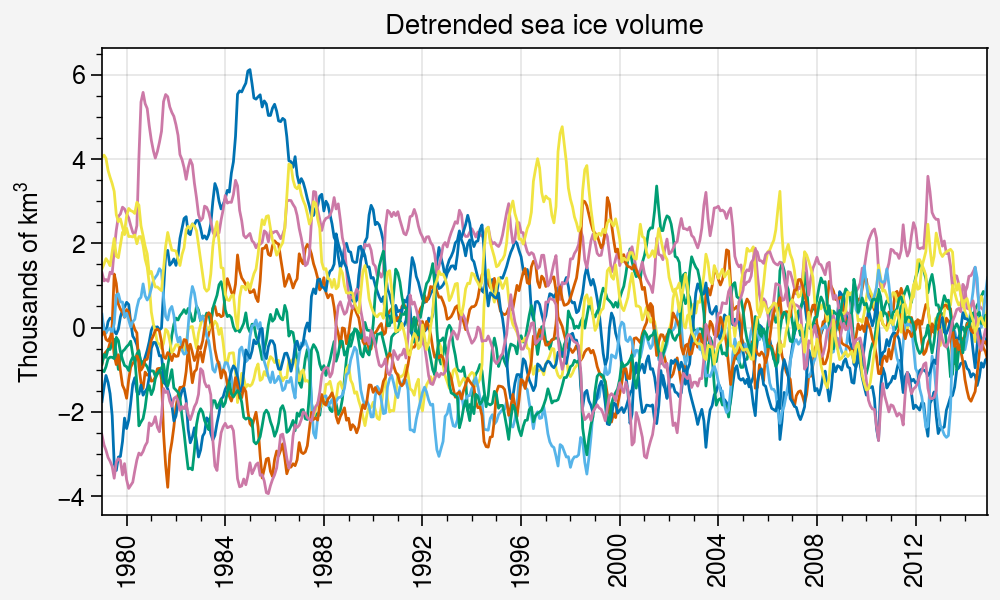

In [55]:
df = pd.read_csv('sivol_data/CESM2.sivol.csv', index_col='time', parse_dates=True)
df.index = pd.to_datetime({'year': df.index.year, 'month': df.index.month, 'day': 1})
# Remove the ensemble mean
ens_mean = df.mean(axis=1)
df_detrended = df.subtract(ens_mean, axis=0)
fig, ax = pplt.subplots(width=5, height=3)
ax.plot(df_detrended/1e12, lw=1)
ax.format(title='Detrended sea ice volume', ylabel='Thousands of km$^3$')

So that's what the inter-annual variability of sea ice volume looks like for CESM2. It looks like it is decreasing over time, and there's probably a strong correlation structure that would be useful to explore sometime. For now, we'll look at the standard deviation in time, and average that across the ensemble members. And we'll do that for the first 10 ensemble members of each model, so the sample size is constant.

In [59]:
data = {}
for file in os.listdir('sivol_data'):
    if 'csv' in file:
        df = pd.read_csv('sivol_data/' + file, index_col='time', parse_dates=True)
        df.index = pd.to_datetime({'year': df.index.year, 'month': df.index.month, 'day': 1})
        # Remove the ensemble mean
        ens_mean = df.mean(axis=1)
        df_detrended = df.subtract(ens_mean, axis=0)
        model = file.split('.')[0]
        data[model] = df_detrended.std(axis=0).iloc[:10]/1e12

In [63]:
# For comparison across models, we take the first 10 ensemble members
subset10 = pd.concat(data).reset_index()
subset10.columns = ['source_id', 'member_id', 'sivol_stdev']

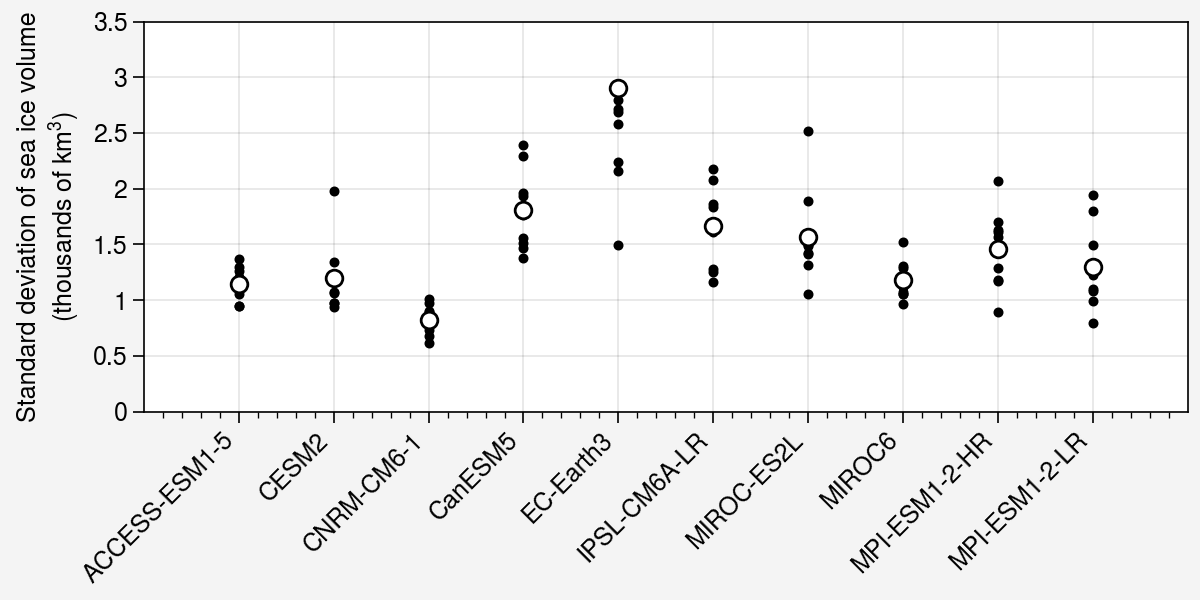

In [74]:
import numpy as np
model_mean = subset10[['source_id', 'sivol_stdev']].groupby('source_id').mean()
model_mean.sort_index(inplace=True)
plot_position = pd.Series(np.arange(len(model_mean)), model_mean.index)

fig, ax = pplt.subplots(width=6, height=3)
ax.plot(plot_position.values,
        model_mean.values, marker='o', lw=0, facecolor='w', edgecolor='k')
for model, data in subset10.groupby('source_id'):
    ax.scatter([plot_position[model]]*10, data['sivol_stdev'].values, marker='.', color='k')
ax.format(xrotation=45, xlim=(-1, len(data)), ytickminor=False,
          xlocator=plot_position.values, xformatter=list(plot_position.index),
          ylim=(0, 3.5), ylabel='Standard deviation of sea ice volume\n(thousands of km$^3$)')

# Multi-model ensemble
To compare across the CMIP6 ensemble we pull the first ensemble member from each model. We can try taking the first approach, where we remove the multimodel mean directly:

In [83]:
multimodel_ensemble = {}
for file in os.listdir('sivol_data'):
    if 'csv' in file:
        df = pd.read_csv('sivol_data/' + file, index_col='time', parse_dates=True)
        df.index = pd.to_datetime({'year': df.index.year, 'month': df.index.month, 'day': 1})
        model = file.split('.')[0]
        multimodel_ensemble[model] = df.iloc[:,0] / 1e12
multimodel_ensemble = pd.DataFrame(multimodel_ensemble)
multimodel_detrended = multimodel_ensemble.subtract(multimodel_ensemble.mean(axis=1), axis=0)

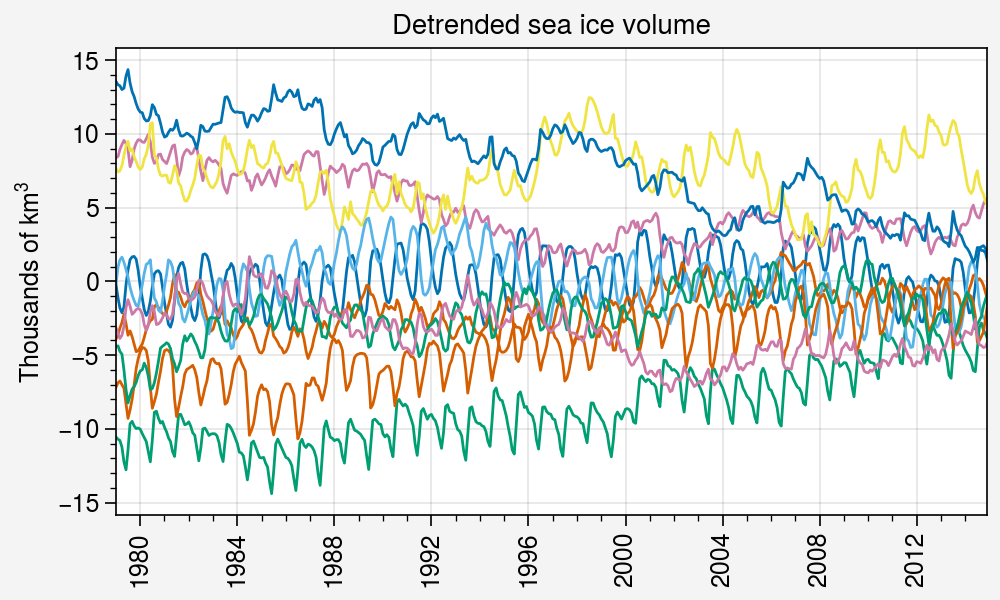

In [84]:
fig, ax = pplt.subplots(width=5, height=3)
ax.plot(multimodel_detrended, lw=1)
ax.format(title='Detrended sea ice volume', ylabel='Thousands of km$^3$')

As can be seen, the seasonal cycle still appears prominently, because each model has different seasonality.

In [93]:
multimodel_ensemble = {}
for file in os.listdir('sivol_data'):
    if 'csv' in file:
        df = pd.read_csv('sivol_data/' + file, index_col='time', parse_dates=True)
        df.index = pd.to_datetime({'year': df.index.year, 'month': df.index.month, 'day': 1})
        model = file.split('.')[0]
        v = df.iloc[:,0] / 1e12
        v = v - v.groupby(v.index.month).transform("mean")
        multimodel_ensemble[model] = v.copy()
        
multimodel_ensemble = pd.DataFrame(multimodel_ensemble)
multimodel_detrended = multimodel_ensemble.subtract(multimodel_ensemble.mean(axis=1), axis=0)

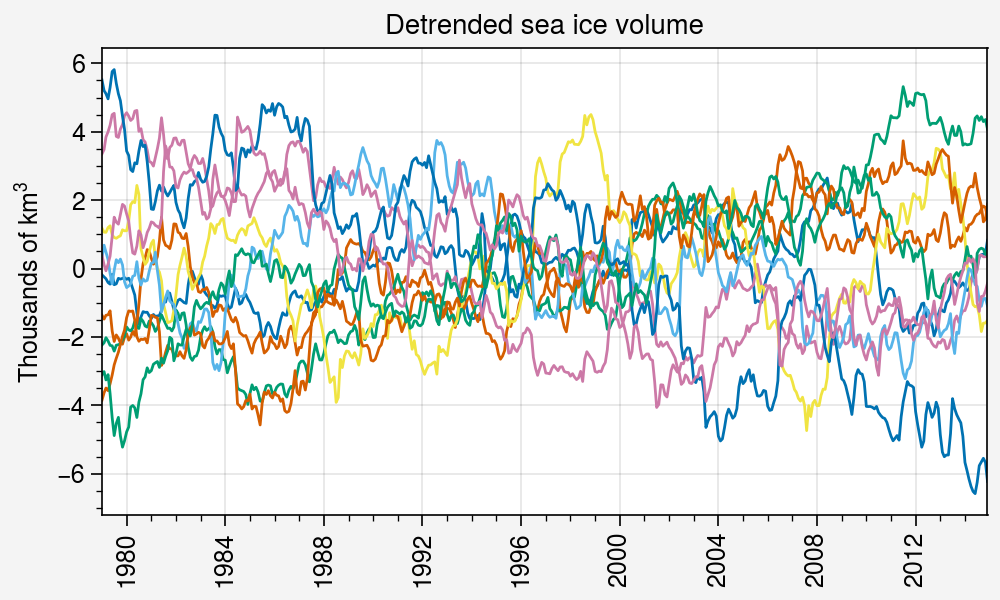

In [94]:
fig, ax = pplt.subplots(width=5, height=3)
ax.plot(multimodel_detrended, lw=1)
ax.format(title='Detrended sea ice volume', ylabel='Thousands of km$^3$')
# Note that individual models have strong trends -- it's the trend across models that is removed. 

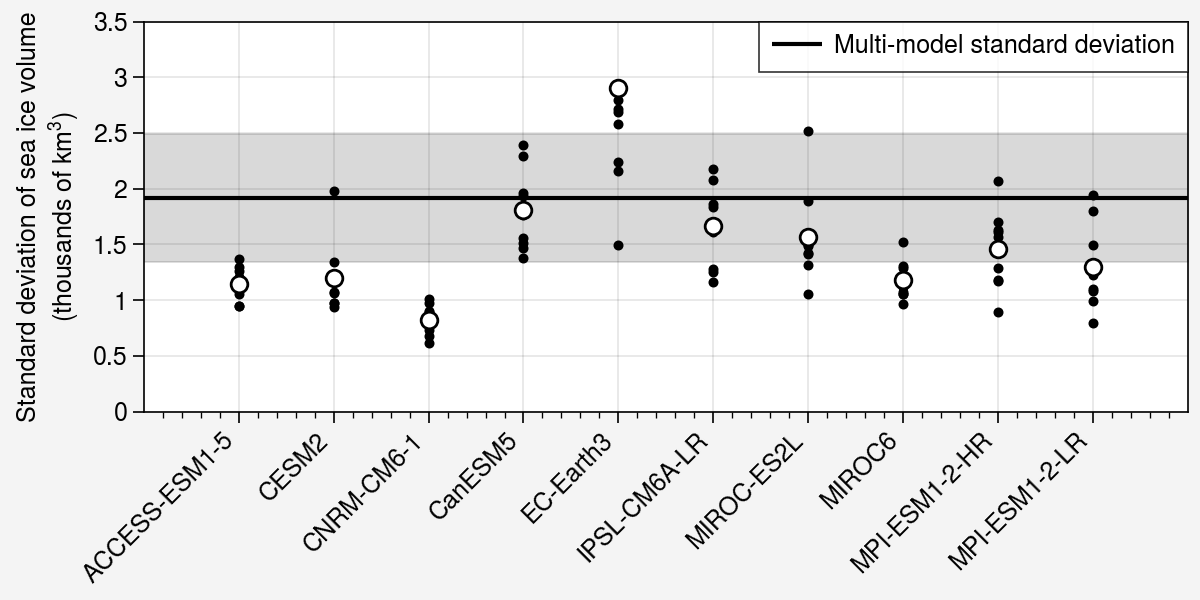

In [106]:
model_mean = subset10[['source_id', 'sivol_stdev']].groupby('source_id').mean()
model_mean.sort_index(inplace=True)
plot_position = pd.Series(np.arange(len(model_mean)), model_mean.index)

fig, ax = pplt.subplots(width=6, height=3)
mmd_mean = multimodel_detrended.std(axis=0).mean()
mmd_std = multimodel_detrended.std(axis=0).std()
ax.axhline(mmd_mean, color='k', label='Multi-model standard deviation')
ax.legend(loc='ur')
ax.fill_between([-1, len(model_mean)],
                mmd_mean - mmd_std, mmd_mean + mmd_std, color='k', alpha=0.15)
ax.plot(plot_position.values,
        model_mean.values, marker='o', lw=0, facecolor='w', edgecolor='k')
for model, data in subset10.groupby('source_id'):
    ax.scatter([plot_position[model]]*10, data['sivol_stdev'].values, marker='.', color='k')

    
ax.format(xrotation=45, xlim=(-1, len(data)), ytickminor=False,
          xlocator=plot_position.values, xformatter=list(plot_position.index),
          ylim=(0, 3.5), ylabel='Standard deviation of sea ice volume\n(thousands of km$^3$)')

# Inter-model spread and individual variables

In [130]:
df_speed = pd.read_csv('sispeed data/CNRM-CM6-1_sispeed.area_mean.csv', index_col='time', parse_dates=True)
df_speed.index = pd.to_datetime({'year': df_speed.index.year, 'month': df_speed.index.month, 'day': 1})

df_wind = pd.read_csv('siwind_file/CNRM-CM6-1_wind_speed.csv', index_col='time', parse_dates=True)
df_wind.index = pd.to_datetime({'year': df_wind.index.year, 'month': df_wind.index.month, 'day': 1})

<a list of 30 Line2D objects>

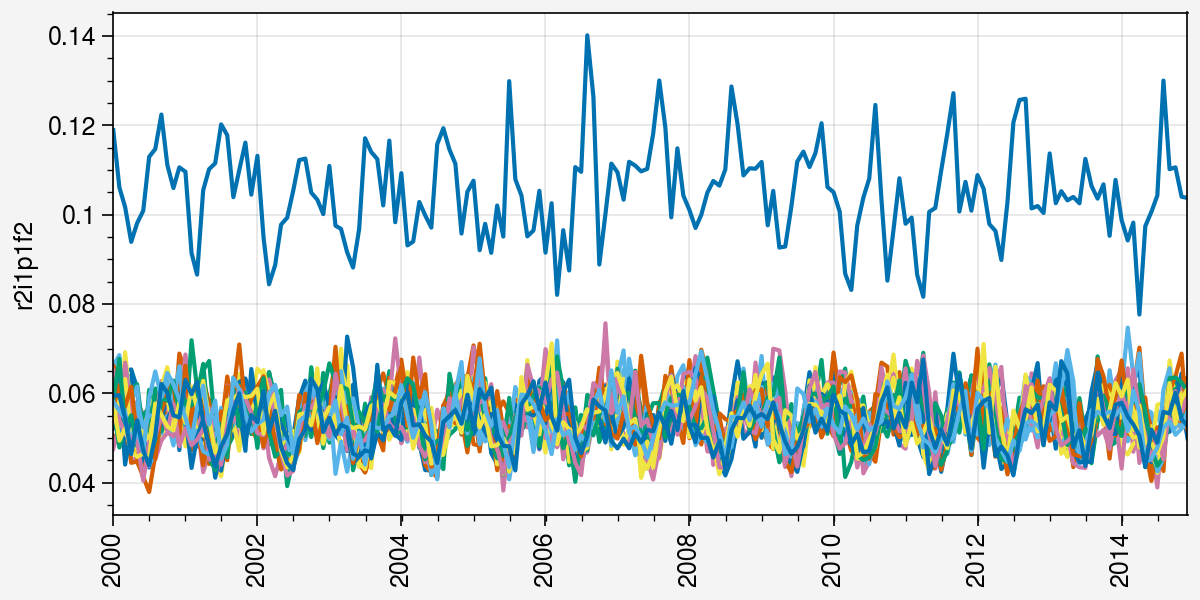

In [137]:
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(df_speed['r2i1p1f2'].loc[slice('2000-01-01', '2014-12-31')])
ax.plot(df_wind*0.01)

In [141]:
for x in df_wind.columns:
    if x in df_speed:
        print(x, df_wind[x].corr(df_speed[x].loc[slice('2000-01-01', '2014-12-31')]))

r1i1p1f2 0.38659540961626226
r2i1p1f2 0.3814775900127394
r7i1p1f2 0.34356258379771065
r9i1p1f2 0.19517222988131758
r6i1p1f2 0.29720195043721054
r5i1p1f2 0.3197828267243846
r4i1p1f2 0.3551815642134309
r8i1p1f2 0.43736275889478504
r3i1p1f2 0.3421906762569548
r10i1p1f2 0.30736444104556826


In [181]:
# This part doesn't work -- likely I'm getting the wrong wind speed columns.
# Seems like the wind speeds don't always have the same ensemble members.

KeyError: "None of [Index(['r1i1p1f1', 'r4i1p1f1', 'r5i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r6i1p1f1',\n       'r8i1p1f1', 'r7i1p1f1', 'r9i1p1f1', 'r10i1p1f1'],\n      dtype='object')] are in the [columns]"

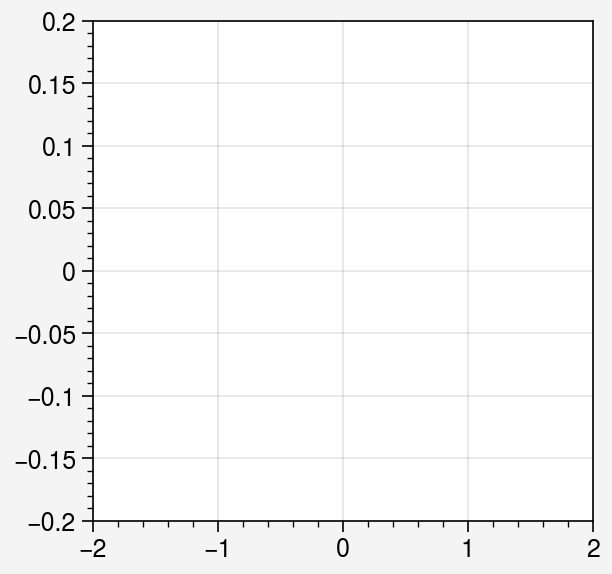

In [176]:
fig, ax = pplt.subplots()
for file in os.listdir('sispeed data/'):
    if 'csv' in file:
        model = file.split('.')[0].replace('_sispeed', '')
        if model in ['CESM2']:
            
            df_dspeed = pd.read_csv('sispeed data/{m}_sispeed.area_mean.csv'.format(m=model), index_col='time', parse_dates=True)
            df_speed.index = pd.to_datetime({'year': df_speed.index.year, 'month': df_speed.index.month, 'day': 1})
    
        
            df_wind = pd.read_csv('siwind_file/{m}_wind_speed.csv'.format(m=model), index_col='time', parse_dates=True)
            df_wind.index = pd.to_datetime({'year': df_wind.index.year, 'month': df_wind.index.month, 'day': 1})
        
            mean_wind = df_wind.iloc[:,:10].mean(axis=0)
            mean_wind_anom = mean_wind - mean_wind.mean()
            
            mean_drift = df_speed.loc[:, mean_wind.index].mean(axis=0)
            mean_drift_anom = mean_drift - mean_drift.mean()
            ax.scatter(mean_wind_anom, mean_drift_anom, label=model, marker='.', )
     
    ax.format(ylim=(-0.2, 0.2), xlim=(-2, 2))

In [178]:
df_wind.columns

Index(['r1i1p1f1', 'r4i1p1f1', 'r5i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r6i1p1f1',
       'r8i1p1f1', 'r7i1p1f1', 'r9i1p1f1', 'r10i1p1f1', 'r11i1p1f1'],
      dtype='object')

In [180]:
df_speed.columns

Index(['r2i1p1f2', 'r5i1p1f2', 'r4i1p1f2', 'r9i1p1f2', 'r1i1p1f2', 'r6i1p1f2',
       'r8i1p1f2', 'r7i1p1f2', 'r10i1p1f2', 'r3i1p1f2'],
      dtype='object')